In [2]:
#pip install spotipy --upgrade

In [1]:
import spotipy
from spotipy.oauth2 import SpotifyOAuth
import pandas as pd
from matplotlib import pyplot as plt

In [109]:
#spotify = spotipy.Spotify(auth_manager=SpotifyOAuth(client_id='a6204bb2c7d44e98af9ab2c2d6518a09', client_secret='df3f58e414574e79b104f6e2ce25fd1c', redirect_uri='http://localhost/', scope = "user-read-recently-played"))


In [110]:
#recent = spotify.current_user_recently_played(50,after=1631156360)

In [3]:
# song_info = []

# for track in recent['items']:
#     song_info.append([track['track']['name'],track['played_at']])
    
# df = pd.DataFrame(song_info, columns=['Song Name', 'Played At'])
# df.head()

In [25]:
def get_history(filename):
    df = pd.read_json(filename)
    return df

In [27]:
df = get_history('MyData/StreamingHistory0.json')
df

,endTime,artistName,trackName,msPlayed
0,2021-01-07 00:57,Fall Out Boy,Thnks fr th Mmrs,73066
1,2021-01-11 16:40,Maccabeats,Mi Yemallel,15978
2,2021-01-14 00:58,Best Instrumentals,Hey There Delilah - Karaoke,232355
3,2021-01-14 01:01,Original Broadway Cast of Hamilton,That Would Be Enough - Instrumental,179141
4,2021-01-14 01:04,ProSound Karaoke Band,A Little Fall of Rain (Karaoke Instrumental Tr...,202867
...,...,...,...,...
3633,2022-01-10 19:09,Panic! At The Disco,Don't Threaten Me with a Good Time,213093
3634,2022-01-10 19:14,Nirvana,Smells Like Teen Spirit,301920
3635,2022-01-10 19:18,Twenty One Pilots,Car Radio,267720
3636,2022-01-10 19:21,Panic! At The Disco,Emperor's New Clothes,158666


In [28]:
def date_information(df):
    df['Date'] = pd.to_datetime(df['endTime']).dt.date
    df['Time'] = pd.to_datetime(df['endTime']).dt.time
    df["Month"] = df['Date'].map(lambda x: x.month)
    df["Year"] = df['Date'].map(lambda x: x.year)
    return df

df = date_information(df)
df

,endTime,artistName,trackName,msPlayed,Date,Time,Month,Year
0,2021-01-07 00:57,Fall Out Boy,Thnks fr th Mmrs,73066,2021-01-07,00:57:00,1,2021
1,2021-01-11 16:40,Maccabeats,Mi Yemallel,15978,2021-01-11,16:40:00,1,2021
2,2021-01-14 00:58,Best Instrumentals,Hey There Delilah - Karaoke,232355,2021-01-14,00:58:00,1,2021
3,2021-01-14 01:01,Original Broadway Cast of Hamilton,That Would Be Enough - Instrumental,179141,2021-01-14,01:01:00,1,2021
4,2021-01-14 01:04,ProSound Karaoke Band,A Little Fall of Rain (Karaoke Instrumental Tr...,202867,2021-01-14,01:04:00,1,2021
...,...,...,...,...,...,...,...,...
3633,2022-01-10 19:09,Panic! At The Disco,Don't Threaten Me with a Good Time,213093,2022-01-10,19:09:00,1,2022
3634,2022-01-10 19:14,Nirvana,Smells Like Teen Spirit,301920,2022-01-10,19:14:00,1,2022
3635,2022-01-10 19:18,Twenty One Pilots,Car Radio,267720,2022-01-10,19:18:00,1,2022
3636,2022-01-10 19:21,Panic! At The Disco,Emperor's New Clothes,158666,2022-01-10,19:21:00,1,2022


In [29]:
df.replace("MONTERO (Call Me By Your Name) - SATAN'S EXTENDED VERSION",'MONTERO (Call Me By Your Name)',inplace=True)

In [30]:
top_10_songs = df['trackName'].value_counts()
top_10_artists = df['artistName'].value_counts()
top_10_songs.head(10), top_10_artists.head(10)

(MONTERO (Call Me By Your Name)    102
 good 4 u                           70
 drivers license                    67
 deja vu                            46
 SUN GOES DOWN                      45
 The Night We Met                   43
 Happier Than Ever                  43
 traitor                            42
 Angel With A Shotgun               40
 brutal                             39
 Name: trackName, dtype: int64,
 Lil Nas X              417
 Olivia Rodrigo         393
 Billie Eilish          349
 Twenty One Pilots      129
 Panic! At The Disco     95
 Fall Out Boy            77
 Maccabeats              69
 Cardi B                 65
 Lil Dicky               48
 Andrew Garfield         47
 Name: artistName, dtype: int64)

In [11]:
dates = df['Date'].unique()

def song_plays_per_day(df, dates):
    song_freqs_df = pd.DataFrame()
    for date in dates:
        value_counts_df = df[df['Date']==date][['trackName','artistName']].value_counts().to_frame().reset_index().rename(columns={0:'Number of Plays'})
        value_counts_df['Date'] = date
        song_freqs_df = song_freqs_df.append(value_counts_df)
    song_freqs_df["Month"] = song_freqs_df['Date'].map(lambda x: x.month)
    song_freqs_df["Year"] = song_freqs_df['Date'].map(lambda x: x.year)
    song_freqs_df.reset_index(drop=True)
    return song_freqs_df

song_freqs_df = song_plays_per_day(df, dates)
song_freqs_df

,trackName,artistName,Number of Plays,Date,Month,Year
0,Thnks fr th Mmrs,Fall Out Boy,1,2021-01-07,1,2021
0,Mi Yemallel,Maccabeats,1,2021-01-11,1,2021
0,For Forever - Instrumental,Piano Dreamers,2,2021-01-14,1,2021
1,That Would Be Enough - Instrumental,Original Broadway Cast of Hamilton,2,2021-01-14,1,2021
2,Washington on Your Side - Instrumental,Original Broadway Cast of Hamilton,2,2021-01-14,1,2021
...,...,...,...,...,...,...
7,Smells Like Teen Spirit,Nirvana,1,2022-01-10,1,2022
8,Surface Pressure,Jessica Darrow,1,2022-01-10,1,2022
9,Uma Thurman,Fall Out Boy,1,2022-01-10,1,2022
10,We Don't Talk About Bruno,Carolina Gaitán - La Gaita,1,2022-01-10,1,2022


In [10]:
top_per_month_df = song_freqs_df.groupby(['Month','Year'])['Number of Plays'].max()
top_per_month_df

Month  Year
1      2021    3
       2022    5
2      2021    2
3      2021    4
4      2021    7
5      2021    6
6      2021    4
7      2021    4
8      2021    4
9      2021    3
10     2021    2
11     2021    3
12     2021    3
Name: Number of Plays, dtype: int64

In [13]:
songs = song_freqs_df['trackName'].unique()
len(songs)

747

TypeError: cannot convert the series to <class 'int'>

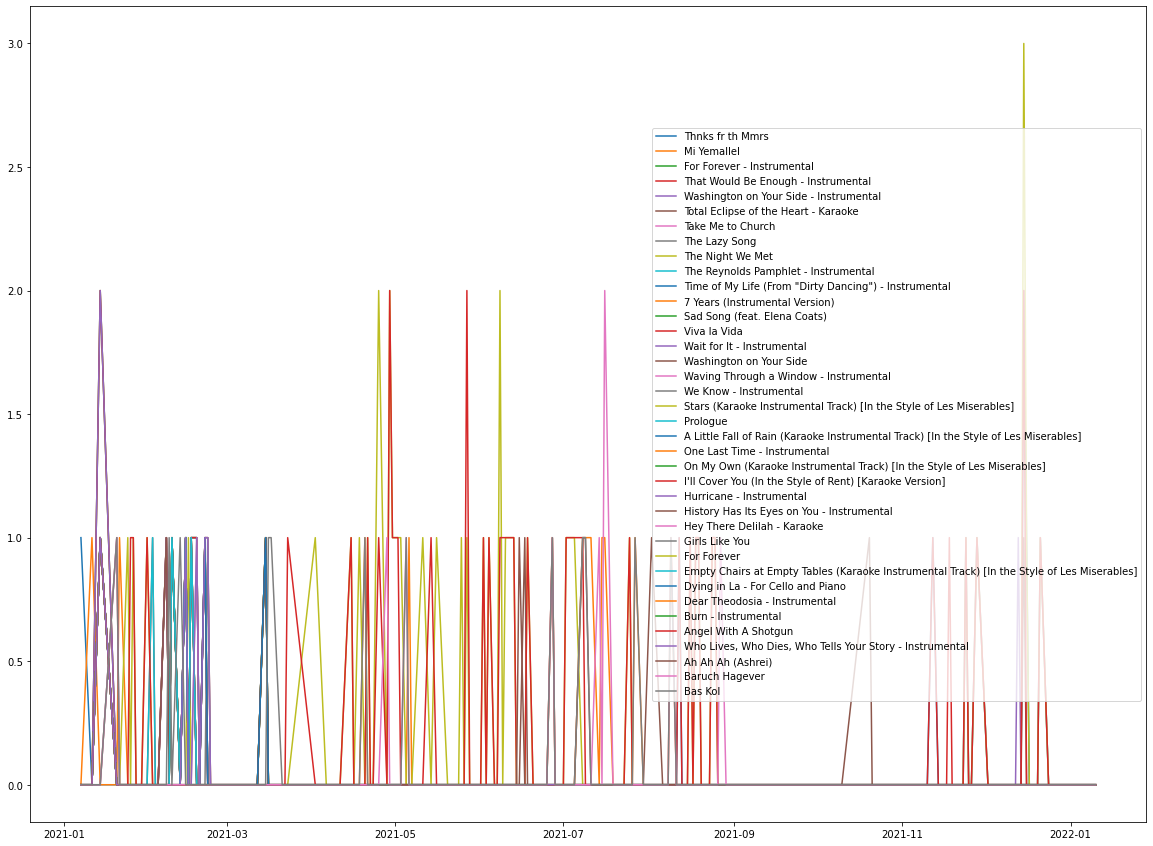

In [22]:
dates = df['Date'].unique()
songs = song_freqs_df['trackName'].unique()

plt.figure(figsize=(20,15))

#def make_plots(songs, dates, song_freqs_df):
for song in songs:
    one_song_freqs = song_freqs_df[song_freqs_df['trackName']==song]
    freq_list = []
    for date in dates:
        if (one_song_freqs['Date']==date).any():
            that_day = one_song_freqs[one_song_freqs['Date']==date]
            freq_list.append(int(that_day['Number of Plays']))
        else:
            freq_list.append(0)
        #return freq_list, song
    plt.plot(dates, freq_list, label=song)
    plt.legend()

#freq_list, song = make_plots(songs, dates, song_freqs_df)   
plt.show()